In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
import arch
import warnings
import portfolio_management_helper as pmh
import hw2_helper as hwh
import portfolio as pf
warnings.filterwarnings("ignore")
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
sns.set_theme()

In [272]:
risk_free_rate = pd.read_excel('C:/Users/文思琪/Downloads/dfa_analysis_data.xlsx', sheet_name='factors')[['Date', 'RF']].set_index('Date')
factors = pd.read_excel('C:/Users/文思琪/Downloads/dfa_analysis_data.xlsx', sheet_name='factors').drop(columns=['RF']).set_index('Date')
portfolio_total_returns = pd.read_excel('C:/Users/文思琪/Downloads/dfa_analysis_data.xlsx', sheet_name='portfolios (total returns)').set_index('Date')


In [273]:
portfolio_excess_returns = portfolio_total_returns.sub(risk_free_rate.values)

1.

In [275]:
def performance_summary(return_data):
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats
factor_summary = performance_summary(factors)
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.0822,0.1847,0.4452,-0.0793
SMB,0.0212,0.1100,0.1929,-0.0422
HML,0.0412,0.1236,0.3337,-0.0421


In [278]:
sub_1980 = factors.loc[:'1980']
sub_2001 = factors.loc['1981':'2001']
sub_2022 = factors.loc['2002':]

df_dict={'1926-1980' : sub_1980,
         '1981-2001' : sub_2001,
         '2002-2022' : sub_2022}

summary_lst = []
for key in df_dict.keys():
    summary_stats = performance_summary(df_dict[key]).loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Factor'}).set_index(['Period','Factor'])
    summary_lst.append(summary_stats)

factor_summary = pd.concat(summary_lst)
factor_summary

Mean  Volatility  Sharpe Ratio  VaR (0.05)
Period    Factor                                              
1926-1980 Mkt-RF  0.0811      0.2051        0.3957     -0.0840
          SMB     0.0340      0.1146        0.2966     -0.0434
          HML     0.0495      0.1338        0.3697     -0.0429
1981-2001 Mkt-RF  0.0773      0.1574        0.4908     -0.0645
          SMB    -0.0009      0.1183       -0.0073     -0.0465
          HML     0.0638      0.1112        0.5736     -0.0418
2002-2022 Mkt-RF  0.0895      0.1546        0.5787     -0.0787
          SMB     0.0110      0.0889        0.1238     -0.0391
          HML     0.0005      0.1073        0.0050     -0.0412

2.

a)
except SMB(the size factor)during 1981-2001, other factors indeed consistently provides positive premium in each subsample.For the SMB factor, it provides premium until 1980, and provides no mean excess returns (discount of 8 basis points), but recovers to provide some premium again between 2002 and 2022.
b)
The premium of the size factor does decline after 1980, going under 0 between 1981 and 2001 and then recovering to ~1.1% (still lower than pre 1980 returns 3.3%).
c)
Yes, the data indicates that the premium to the value factor (represented by HML, which stands for "High Minus Low" book-to-market ratio) appears to decrease during the 1990s. Here's an analysis based on the table:
1926-1980 Period: The mean for the HML factor is 0.0495.
1981-2001 Period: The mean for the HML factor increases to 0.0638, suggesting a strong performance of value stocks over growth stocks during this period.
2002-2022 Period: The mean for the HML factor drops to 0.0005, indicating a significantly reduced premium for value stocks.
The 1990s are captured within the 1981-2001 period, during which the HML premium was relatively strong. However, it's notable that by the early 2000s, the premium sharply declined, suggesting that the 1990s might have been a peak period before the premium started to decrease.
d)The period from 2002 to the present shows lower premiums for both the size and value factors, signaling a shift in investor behavior or changes in market dynamics.
1.Value investing, which was traditionally a strong performer, has not been as effective since 2002.
2.Market factor returns remained relatively strong, indicating that broad market exposure provided better returns than strategies based on size or value premiums.
This aligns with broader market trends where growth stocks, particularly in technology, have dominated in recent years, contributing to the reduced efficacy of traditional value-based strategies.


3.

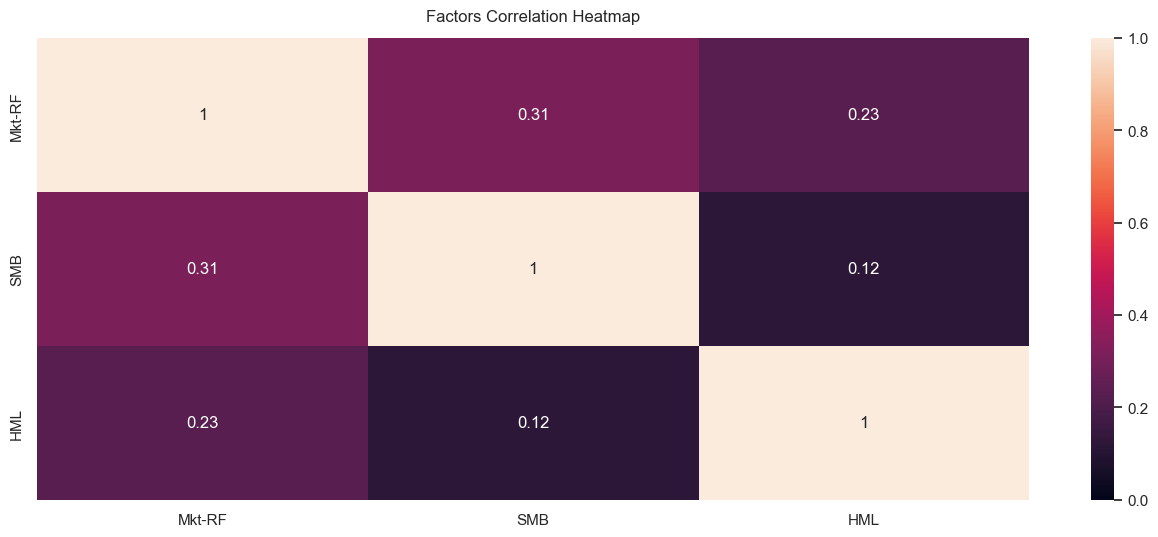

In [284]:
factor_corr = factors.corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(factor_corr, vmin=0, vmax=1, annot=True)
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

The correlations among the three factors are low, indicating that the construction method has effectively achieved its goal. The Size and Value factors, in particular, exhibit very low correlations, although they remain somewhat more closely linked to the market factor with correlation 0.31 and 0.23.

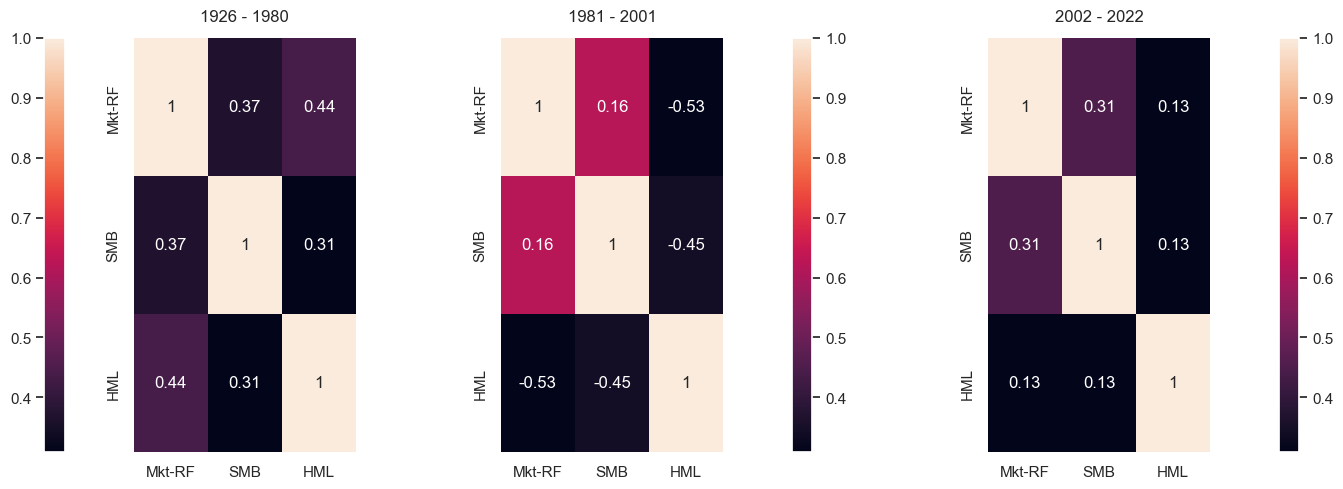

In [287]:
fig, (ax,ax2,ax3) = plt.subplots(ncols=3)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)
sns.heatmap(sub_1980.corr(), ax=ax, cbar=False, annot = True).set_title('1926 - 1980', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(sub_2001.corr(), ax=ax2, cbar=False, annot = True).set_title('1981 - 2001', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

sns.heatmap(sub_2022.corr(), ax=ax3, cbar=False, annot = True).set_title('2002 - 2022', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0],ax=ax3,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

the HML and SMB have low correlation during 2002-2022 but higher correlation during 1926-2001.And with Mkt-RF,HML has low correlation with it during 2002-2022, and high positive correlation during 1926-1980, and high negetive correlation during 1981-2001; SMB has high correlation during 1926-1980 and 2002-2022, and low correlation during 1981-2001.

4.

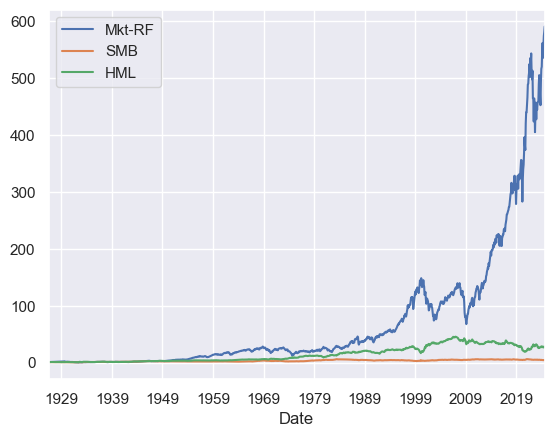

<Figure size 10000x600 with 0 Axes>

In [290]:
figure = ((factors + 1).cumprod()).plot()
plt.figure(figsize=(100, 6))
plt.show()

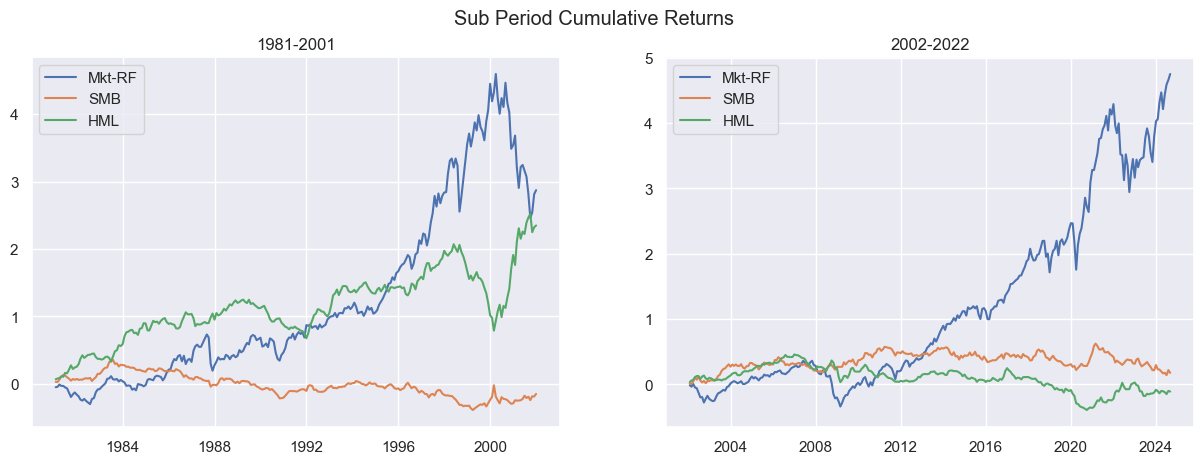

In [292]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((sub_2001 + 1).cumprod() - 1))
ax2.plot(((sub_2022 + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(sub_2001.columns)
ax2.legend(sub_2022.columns)

ax1.title.set_text('1981-2001')
ax2.title.set_text('2002-2022')

according to this plot, it shows that Mkt factor has great performance during the whole period. And SMB seems don't have signifacate effect on cumulative returns and HML perform a little better.The Market-factor significantly outperforms Size and Value in the 2002-2022 sub-sample. So I think for DFA, it is better to transform other factors with more signifacate effect.The size factor seems our of favor for a long time now and the returns seem correlated to the Market Factor.

3.1

In [295]:
port_summary = performance_summary(portfolio_excess_returns.loc['1981-01-01':])
port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]
port_summary_sorted = port_summary.loc[:, ['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (0.05)']].sort_values(by='Mean', ascending=False)
port_summary_sorted

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL HiBM,0.1278,0.2100,0.6086,-0.0885
ME3 BM5,0.1239,0.2034,0.6091,-0.0842
ME1 BM4,0.1160,0.1943,0.5971,-0.0770
ME2 BM5,0.1160,0.2156,0.5380,-0.0964
ME2 BM4,0.1088,0.1821,0.5977,-0.0761
ME3 BM4,0.1088,0.1809,0.6013,-0.0718
ME4 BM5,0.1082,0.1988,0.5444,-0.0834
ME3 BM2,0.1072,0.1886,0.5684,-0.0785
ME2 BM3,0.1059,0.1858,0.5703,-0.0785
ME4 BM4,0.1017,0.1761,0.5776,-0.0695


Text(0, 0.5, 'Mean Excess Returns')

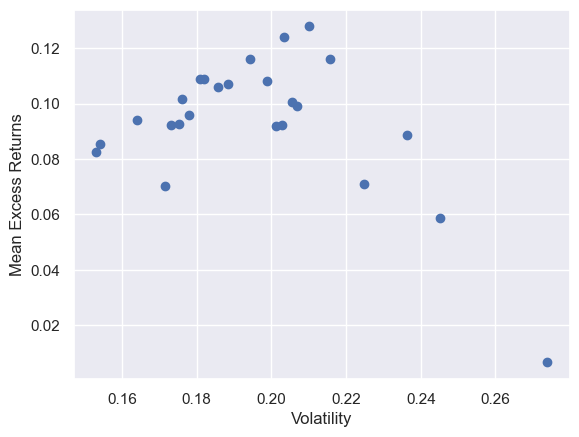

In [297]:
plt.scatter(port_summary.loc[:,['Volatility']],port_summary.loc[:,['Mean']])
plt.xlabel("Volatility")
plt.ylabel("Mean Excess Returns")

Text(0, 0.5, 'Mean Excess Returns')

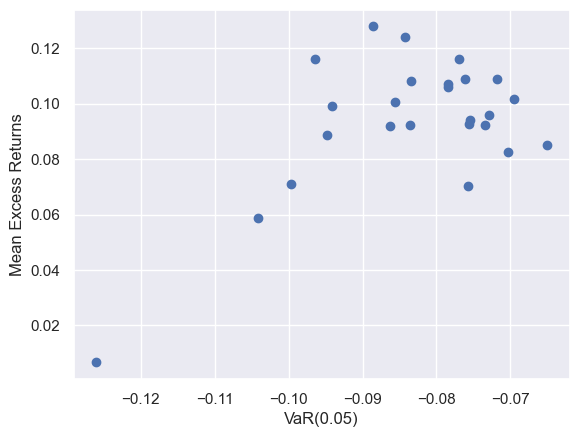

In [298]:
plt.scatter( port_summary.loc[:,['VaR (0.05)']],port_summary.loc[:,['Mean']])
plt.xlabel("VaR(0.05)")
plt.ylabel("Mean Excess Returns")

Based on the table, we do not get a clear indication if the differences in the mean excess returns are explained by differences in either their VaR or their Volatility.Because with highest return, it's volatility is not so big. In conception, with high vol, it should have high return and low VAR. So we can draw a scatter polt to see their relationship.It can not see obvious linear relationship between VAR pr Volatility and return. Although A linear pattern can be observed between volatility and mean excess returns to support the previous arguments, but the evidence is not very concrete from the plots below.

3.2

In [301]:
def time_series_regression(portfolio, factors, FF3F = False, resid = False):
    
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * 12
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_report.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(12) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = 12 * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(12))

        if resid:
            bm_residuals[portf] = res.resid
            
            
        
    if resid:
        return bm_residuals
        
    return ff_report
ts_CAPM = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,'Mkt-RF'])
ts_CAPM

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.1067,1.3564,-0.6134,0.0049,0.5961,0.1740
ME1 BM2,-0.0088,1.1657,-0.0580,0.0761,0.5905,0.1513
ME1 BM3,0.0046,1.0452,0.0391,0.0880,0.6550,0.1182
ME1 BM4,0.0347,0.9725,0.2854,0.1193,0.6085,0.1216
SMALL HiBM,0.0447,0.9950,0.3151,0.1285,0.5450,0.1417
ME2 BM1,-0.0530,1.3386,-0.4119,0.0440,0.7240,0.1288
ME2 BM2,0.0056,1.1349,0.0538,0.0886,0.7405,0.1047
ME2 BM3,0.0199,1.0286,0.2124,0.1030,0.7445,0.0939
ME2 BM4,0.0273,0.9747,0.2722,0.1117,0.6957,0.1004
ME2 BM5,0.0228,1.1144,0.1786,0.1041,0.6487,0.1278


In [302]:
MAE = ts_CAPM['alpha_hat'].abs().mean()
print(f"Mean Absolute Error (MAE): {MAE}")

Mean Absolute Error (MAE): 0.022428026900773758


a)1.For Treynor, if CAPM is true, we should observe the same Treynor Ratios for 25 stocks as the portfolio returns should completely be a function of SPY.However, as we observe, most portfolios have varying Treynor ratios.
2.For Alphas, it should similarly have been lower (ideally 0) for all portfolios, but we observe, that the alphas are still higher than expected.
3.For information ratios, it should also similarly have been lower (ideally 0) for all portfolios due to low absolute magnitude of the residuals. But we observe, the Information ratios are higher than expected indicating towards presence of other regressors that should be included in the model.
b) MAE should nearly be 0 if the CAPM hold.

3.3

In [307]:
portfolio = portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns')
time_series_regression(portfolio, ts_CAPM['beta_mkt'])

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.2086,-0.0090,35.4047,-10.4114,0.3006,0.0059


we would expect a very low alpha, a high beta and a very high R-Squared from the above regression. Since, all market betas should be explaining the same factor i.e. SPY, we should expect them to be heavily correlated，as the same as high beta.

3.4
Low R-Squared(0.3006) and Betas(-0.0090) and higher alpha(0.2086) from the cross-sectional regression in the previous question, indicat the presence of other risk factors in the market that can explain excess returns of equity portfolios.Also in the Question 2 we can see size and value factor have high expaination power for the excess return in market.

4

4.1

In [357]:
tangency_r=portfolio_excess_returns.loc['1981':]@pmh.calc_tangency_weights(portfolio_excess_returns.loc['1981':])
tan_regression_test=time_series_regression(portfolio_excess_returns.loc['1981':], tangency_r)
print('MAE is %s.' %(round(np.mean(tan_regression_test['alpha_hat'].abs()),4)))
tan_regression_test.loc[:,['alpha_hat','beta_mkt']]

MAE is 0.0.


,alpha_hat,beta_mkt
SMALL LoBM,-0.0000,0.0174
ME1 BM2,-0.0000,0.2315
ME1 BM3,-0.0000,0.2402
ME1 BM4,-0.0000,0.3028
SMALL HiBM,-0.0000,0.3338
ME2 BM1,-0.0000,0.1537
ME2 BM2,-0.0000,0.2624
ME2 BM3,-0.0000,0.2766
ME2 BM4,-0.0000,0.2841
ME2 BM5,-0.0000,0.3028


In [359]:
regression_test=time_series_regression(portfolio, tan_regression_test['beta_mkt'])
regression_test.columns=[['intercept', 'coefficient', 'info_ratio', 'treynor_ratio', 'R-squared','Tracking Error']]
regression_test.loc[:,['intercept', 'coefficient','R-squared']]

,intercept,coefficient,R-squared
Mean Portfolio excess returns,-0.0000,0.0319,1.0000


We observe 0 alphas and information ratio and high betas and R square, which supports CAPM.

4.2

In [363]:
ts_FF3F = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':],True)
print('MAE is %s.' %(round(np.mean(ts_FF3F['alpha_hat'].abs()),4)))
ts_FF3F

MAE is 0.0145.


,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.0858,1.1118,1.3925,-0.2538,-0.9375,0.0060,0.8882,0.0915
ME1 BM2,0.0014,0.9655,1.3177,-0.0144,0.0203,0.0919,0.9109,0.0706
ME1 BM3,0.0006,0.9231,1.0651,0.2774,0.0120,0.0997,0.9393,0.0496
ME1 BM4,0.0222,0.8778,1.0658,0.4774,0.4673,0.1321,0.9403,0.0475
SMALL HiBM,0.0231,0.9298,1.0660,0.6914,0.3120,0.1375,0.8763,0.0739
ME2 BM1,-0.0324,1.1419,1.0233,-0.3103,-0.5395,0.0516,0.9399,0.0601
ME2 BM2,0.0072,1.0138,0.9159,0.1213,0.1412,0.0991,0.9393,0.0506
ME2 BM3,0.0087,0.9740,0.7192,0.3892,0.1656,0.1088,0.9208,0.0523
ME2 BM4,0.0084,0.9413,0.7483,0.5751,0.1861,0.1156,0.9390,0.0450
ME2 BM5,-0.0058,1.0892,0.9298,0.8328,-0.1243,0.1065,0.9536,0.0464


In [351]:
portfolio = portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns')
time_series_regression(portfolio, ts_FF3F.loc[:,['beta_mkt','Size beta','Value beta']], True)

,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.1865,-0.0083,-0.0002,0.0029,36.1123,-11.2427,0.4628,0.0052


4.3

In [353]:
resid = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,'Mkt-RF'], False, True)

In [355]:
T = portfolio_excess_returns['1981':].shape[0]
SR = factors['1981':]['Mkt-RF'].mean() *12/ factors['1981':]['Mkt-RF'].std()*np.sqrt(12)
Sigma = resid.cov()
Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=Sigma.index, columns=Sigma.columns)
alpha = ts_CAPM['alpha_hat']

H = T * (1 + SR**2)**(-1) * (alpha @ Sigma_inv @ alpha)

print('H = {:.2f}'.format(H))
pvalue = 1 - stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))

H = 472.07
p-value = 0.0000


a)By definition, a joint test is stricter than testing the conditions individually.

b)
The core of this test is actually about comparing the square of the Sharpe ratio of the alphas with the square of the Sharpe ratio of the factors. If the Sharpe ratio of the alphas is higher, then investing in these alphas would be better than solely relying on the factors, implying that the alphas provide additional investment value

Therefore, the essence of this test is to see whether these alphas can deliver more returns than the current optimal portfolio (the tangency portfolio) H  \) is significant, it means these alphas can bring returns that exceed those of the tangency portfolio.